# Clust default normalization

1. Take median between replicates
2. Default normalization: quantile normalization -> log2 transformation -> z-score normalization

## Quantile normalization

Is a global, i.e., sample-wise, normalization technique aimed at removing technical variation between samples. It is based on the assumption that the distribution of expression values is similar across all samples. The method consists of the following steps: (1) sort the expression values for each gene in each sample; (2) compute the average expression value for each gene across samples; (3) replace the expression values for each gene in each sample with the average expression value for that gene across samples.

However, when the differences in the global distribution of expression values across samples is due to biological variation, quantile normalization is not a good idea, since it will remove biological variation.

Transcript / Cell - transform data shows large variation in the distribution of expression values across samples. Not sure this is due to biological variation or due to an artifact of the transformation.

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import sem

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser, GenomeGBK, add_pathways_to_deseq_df

%matplotlib inline


root_dir = Path(os.getcwd())
results_dir = root_dir / "results"
data_dir = root_dir / "data"

In [2]:
def plot_density(df, ax=None, show_plot=True, title=None, show_legend=False):
    sns.set(style="whitegrid")
    if ax is None:
        fig, ax = plt.subplots()

    qn_df = quantile_normalize(df)
    qn_sample = qn_df.iloc[:, 0]

    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            sns.kdeplot(df[column], label=column, ax=ax, alpha=1)

    sns.kdeplot(qn_sample, label='Quantile Normalized', ax=ax, alpha=0.5, color='black', lw=2.8)
    if show_legend:
        ax.legend()
    ax.set_xlabel('log2(expression)')
    ax.set_ylabel('Density')
    if title is not None:
        ax.set_title(title)
    if show_plot:
        plt.show()
    return ax


def take_average_values(df, method="median"):
    index_name = df.index.name
    df_long = df.reset_index().melt(id_vars=index_name, var_name='Column', value_name='Value')
    df_long['Temperature'] = df_long['Column'].str.extract('_(\d+)_')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'])

    if method == "mean":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].mean().reset_index()
    elif method == "median":
        aggregated_values = df_long.groupby([index_name, 'Temperature'])['Value'].median().reset_index()
    else:
        raise ValueError("Invalid method. Please use 'mean' or 'median'.")

    return aggregated_values.pivot_table(index=index_name, columns='Temperature', values='Value')


def z_normalize(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(ddof=0), axis=1)


def log2_normalize(df):
    return df.applymap(np.log2)


def quantile_normalize(df):
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

## Load counts

In [3]:
min_count = 10

counts = pd.read_csv(data_dir / 'DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)

Text(0, 0.5, 'Median counts')

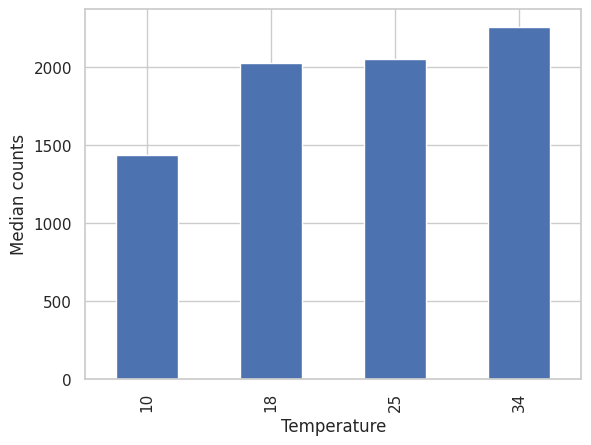

In [35]:
ax = take_average_values(counts.set_index("index")).median().plot(kind='bar')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median counts')

## Get Transcript / Cell from Abundance Data

In [5]:
volume_meta = pd.read_excel(data_dir / "Laura_Normalization" / "Datos_Dokdonia_9Jun23.xlsx")
volume_meta["Sample"] = volume_meta['Light/Dark'] + '_' + volume_meta['Temperature'].astype(str) + '_' + volume_meta['Replicate']
volume_meta.head()

,Temperature,Light/Dark,Replicate,Total biovolume (um3),Total abundance (cells),Avg_Standard_ratio,Sample
0,10,L,R1,2.294207e+08,7.609607e+08,7128.171978,L_10_R1
1,10,L,R2,1.803365e+08,5.434251e+08,22976.436275,L_10_R2
2,10,L,R3,1.960539e+08,6.095364e+08,20778.875834,L_10_R3
3,10,D,R1,1.841892e+08,5.789344e+08,12210.079577,D_10_R1
4,10,D,R2,1.900776e+08,5.737051e+08,18207.999370,D_10_R2


In [6]:
TC_new, TV = DE.get_transcripts_volume(counts, volume_meta, ["D_25_R1"])
TC_new = TC_new.set_index("index")
TV = TV.set_index("index")

/tmp/ipykernel_8270/1113300778.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = volume_meta.groupby('Temperature').mean()


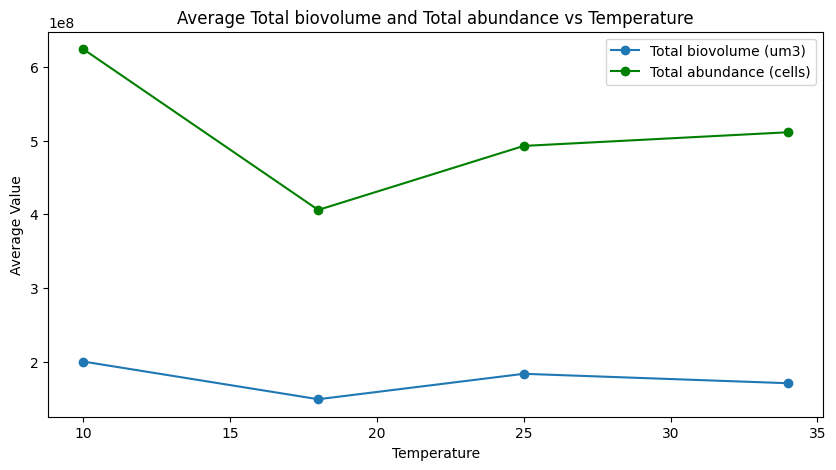

In [7]:
import matplotlib.pyplot as plt

# Group the data by 'Temperature' and calculate the mean
grouped = volume_meta.groupby('Temperature').mean()

# Create a new figure
plt.figure(figsize=(10, 5))

# Plot the average 'Total biovolume' for each 'Temperature'
plt.plot(grouped.index, grouped['Total biovolume (um3)'], marker='o', label='Total biovolume (um3)')

# Plot the average 'Total abundance' for each 'Temperature'
plt.plot(grouped.index, grouped['Total abundance (cells)'], marker='o', color='green', label='Total abundance (cells)')

plt.title('Average Total biovolume and Total abundance vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Average Value')
plt.legend()

# Show the plot
plt.show()


There were more cells at 10 degrees. The question is: the sample that was sequenced contained the same amount of RNA than the other ones or was it measured by volume of culture media instead of total RNA? That is, was this size effect taken into account prior to sequencing?

__UPDATE__

Alright, after ploting total counts per each temperature, we can see that at 10 degrees there are _less_ total counts AND also more cells! So even less total RNA per cell than in other samples. Hence, when correcting by number of cells, expression values get really low at 10 degrees. This could actually be a biological effect, so cells at 10 degrees are really struggling to express their genes (or being more efficient doing it).

DeSeq2 internally corrects for library size, but obviously is oblivious to the large number of cells at 10 degrees and does not take this into account (only the library size.). This could explain the differences we were observing between temperatures and methods.

This assuming that the same volume of culture media was used to collect RNA from all samples.

__Question__

Cell abundance was measured from the final culture media that was filtered to extract RNA?

Refs:

https://www.biostars.org/p/9551775/

http://bioconductor.org/books/3.14/OSCA.basic/normalization.html

http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#why-un-normalized-counts:~:text=Input%20data-,Why%20un%2Dnormalized%20counts%3F,-As%20input%2C%20the

## Compute only counts scaled by average internal standard and by abundance

In [8]:
abundance_meta = pd.read_excel(data_dir / "Laura_Normalization" / "Abundancias_Dokdonia.xlsx")
counts_IS = DE.scale_counts_by_internal_standard(counts, abundance_meta)

## Get DeSeq2 normalized counts

In [9]:
# Deseq2 normalization
colfactor = pd.DataFrame(
    {'Sample': counts.columns, 'Temperature': counts.columns.str.extract(r'_(\d+)_', expand=False)}
    ).iloc[1:, :].set_index('Sample', inplace=False)
colfactor.head()

deseq2_counts = DE.deseq2Normalize(counts, colfactor,
                gene_column="index",
                design_formula="~ Temperature")

INFO:DESeq2:Normalizing counts


Text(0, 0.5, 'Median DeSeq2-norm counts')

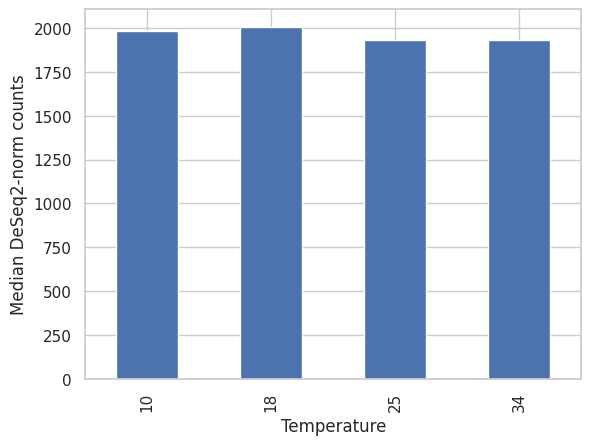

In [33]:
ax = take_average_values(deseq2_counts.set_index("index")).median().plot(kind='bar')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median DeSeq2-norm counts')


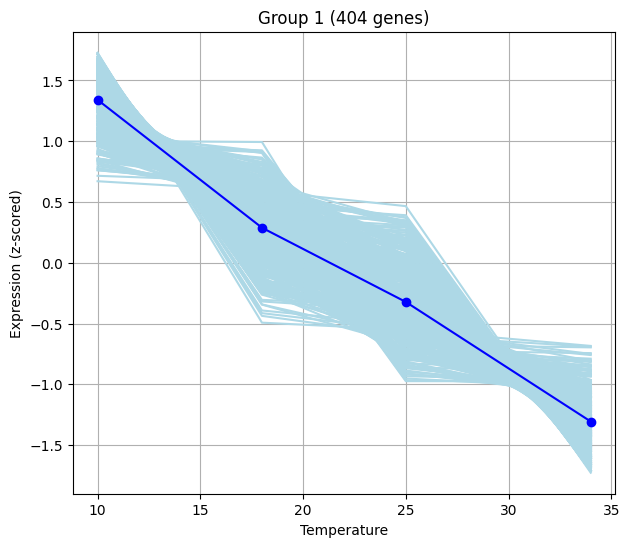

In [11]:
deseq2_Z = z_normalize(take_average_values(deseq2_counts.set_index("index")))

group1 = deseq2_Z[(
    (deseq2_Z[10] > deseq2_Z[18]) &
    (deseq2_Z[18] > deseq2_Z[25]) &
    (deseq2_Z[25] > deseq2_Z[34])
    )]

mean1 = group1.mean()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))
for index, row in group1.iterrows():
    axes.plot(row.index, row, color='lightblue')
# Plot the mean for group 1 on top
mean1.plot(ax=axes, color='blue', marker='o')
axes.set_title(f'Group 1 ({group1.shape[0]} genes)')
axes.set_ylabel('Expression (z-scored)')
axes.grid(True)

## Get TPM values

In [12]:
# TPM-normalize count data
patric_file = pd.read_csv(data_dir / "Function_Annotations/PATRIC/Dokdonia_MED134_Craig_PATRIC_genome_feature.csv")
tpm = DE.tpmNormalize(counts, patric_file).set_index("index")

# Compare distributions

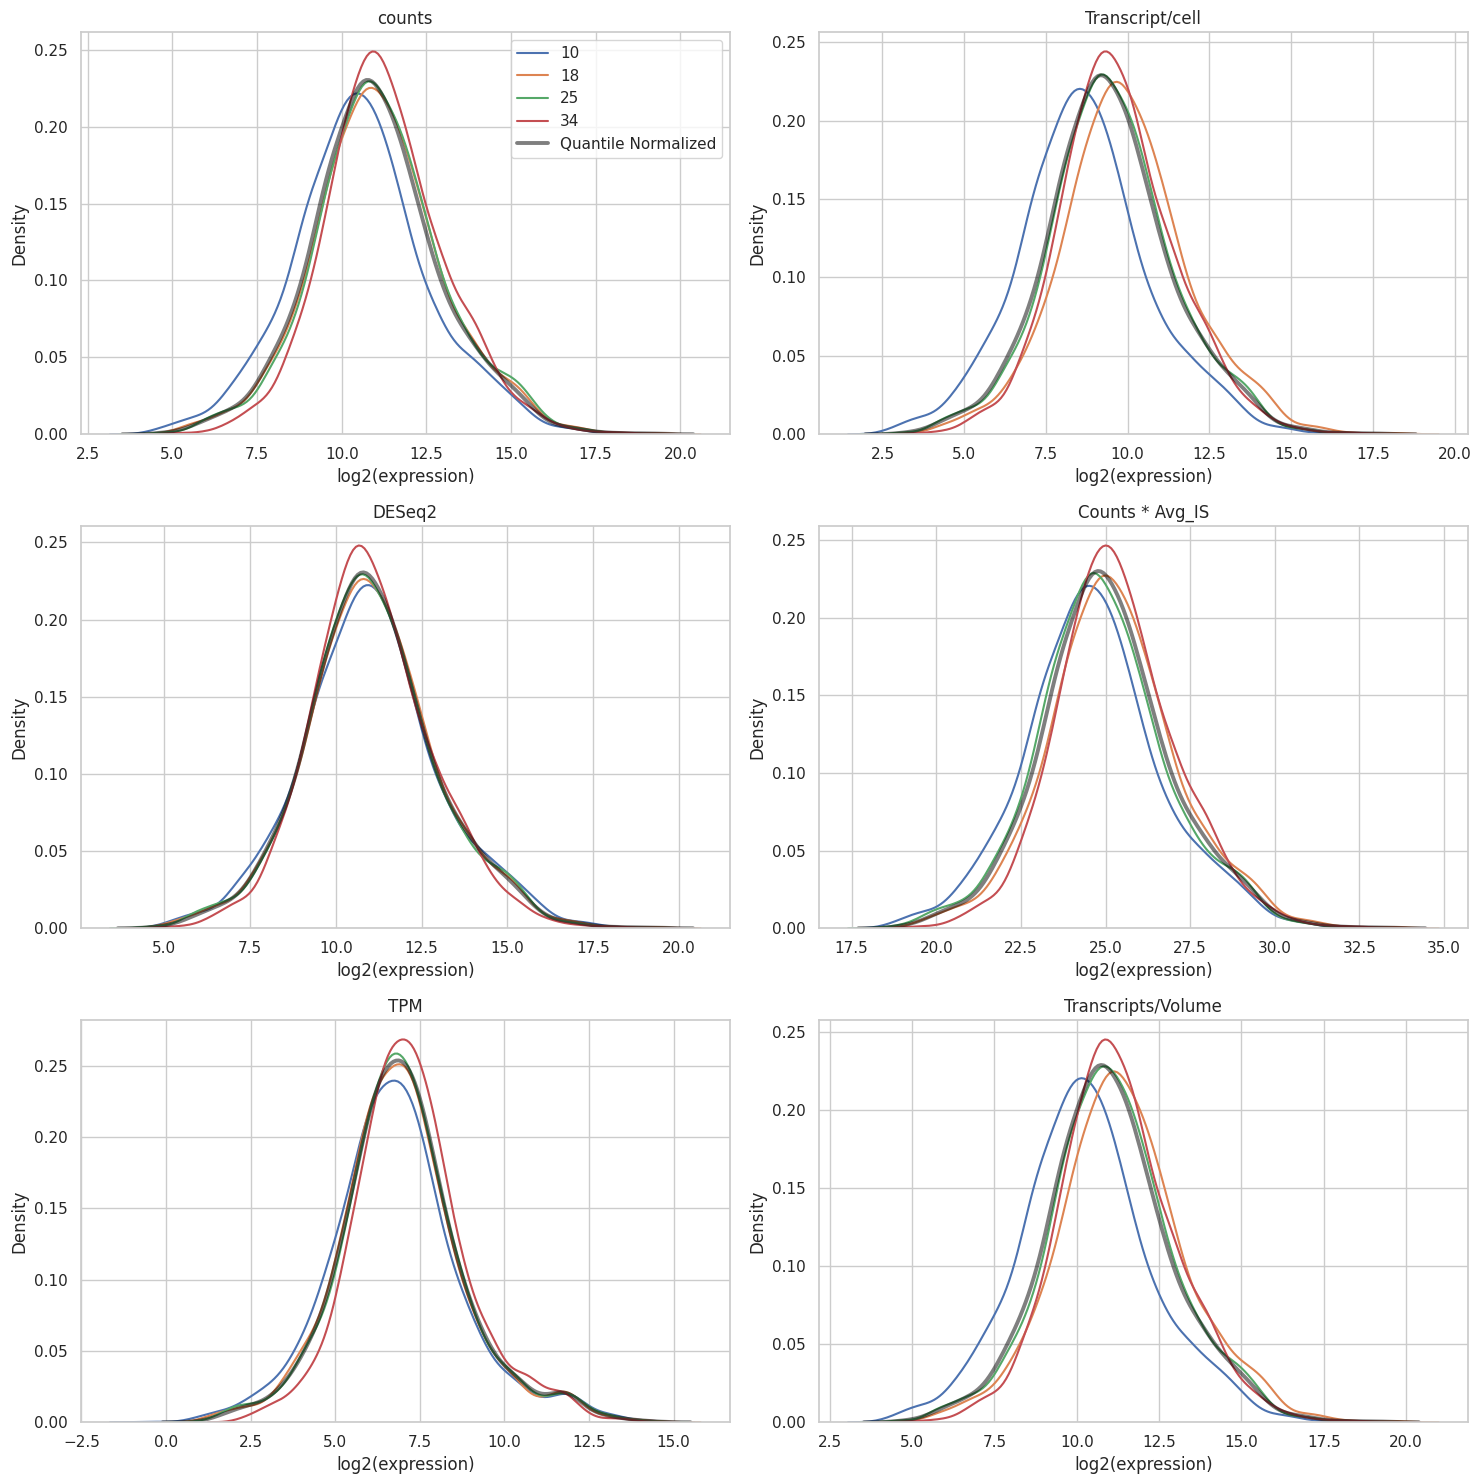

In [14]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

plot_density(log2_normalize(take_average_values(counts.set_index("index"))), ax=axs[0, 0], show_plot=False, title="counts", show_legend=True)
plot_density(log2_normalize(take_average_values(deseq2_counts.set_index("index"))), ax=axs[1, 0], show_plot=False, title="DESeq2")
plot_density(log2_normalize(take_average_values(TC_new * 1e4)), ax=axs[0, 1], show_plot=False, title="Transcript/cell")
plot_density(log2_normalize(take_average_values(tpm)), ax=axs[2, 0], show_plot=False, title="TPM")
plot_density(log2_normalize(take_average_values(counts_IS.set_index("index"))), ax=axs[1, 1], show_plot=False, title="Counts * Avg_IS")
plot_density(log2_normalize(take_average_values(TV * 1e4)), ax=axs[2, 1], show_plot=False, title="Transcripts/Volume")

plt.tight_layout()
plt.show()

In transcript / cell data, the distribution of expression values is quite different between samples. This is not the case for the DeSeq2 normalized counts or TPM values. Particularly, samples at 10º show lower expression values than the average, and samples at 18º higher expression values than the average. Thus, this variation is introduced by the transcript / cell transformation.

This observation also explains why the pattern showed in the clustering of transcript / cell data breaks down when quantile normalization is reversed.

Another point:

At 10 degrees, total RNA per cell is much lower than in other temperatures. Thus, when comparing gene expression across temperatures, gene expression will tend to be smaller at 10 for any gene. Is it fair to compare gene expression for a given gene across temperatures considering than the RNA pool per cell is smaller at 10? 

# Clustering with Transcripts / Volume

## Find  DE genes

In [15]:
gbk = GenomeGBK(data_dir / 'DokdoniaMED134.gbk')

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


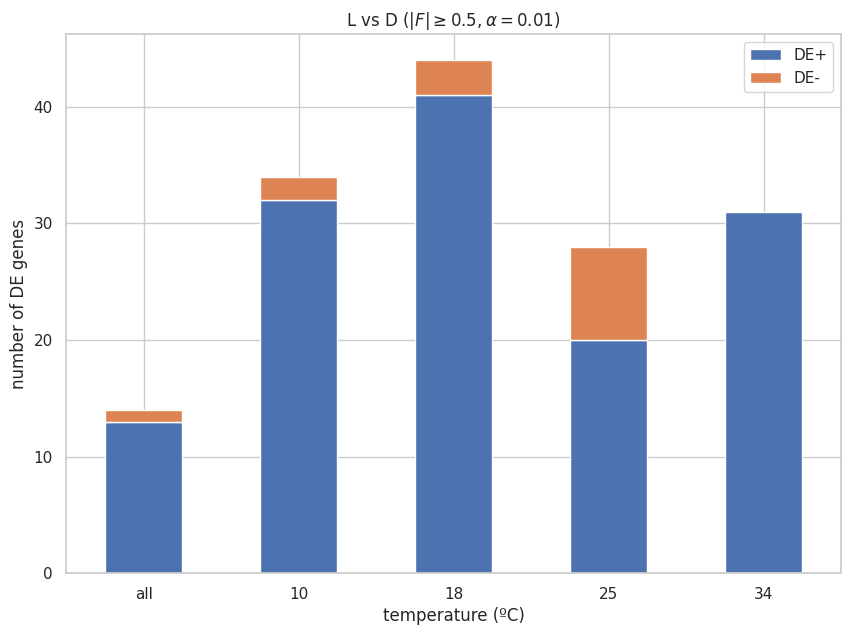

In [16]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [17]:
from functools import reduce


DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange >= k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
        'D>L': add_pathways_to_deseq_df(
            res.loc[res.log2FoldChange <= -k].sort_values(by="log2FoldChange", ascending=False),
            gbk,
            gene_pathways,
            gene_systems
        ),
    }

In [18]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


There are 1930 out of 2877 genes which are DE across all temperature values


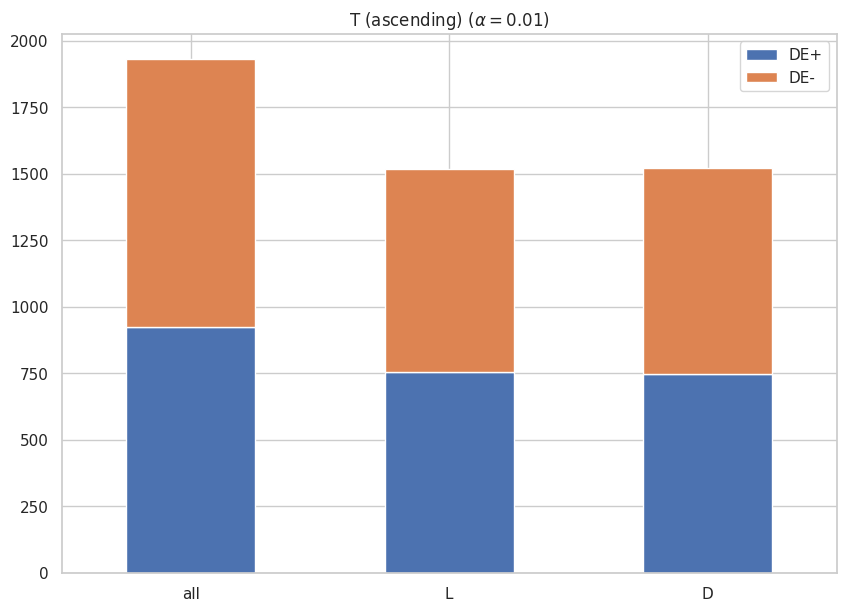

In [19]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

# Find genes which are DE across the temperature range
DE_genes_across_T = list(T_res["all"].index)
print(f"There are {len(DE_genes_across_T)} out of {counts.shape[0]} genes which are DE across all temperature values")

## Remove Light/Dark DE genes from datasets

In [20]:
# Remove light-dark DE genes from TC dataset
TCnoDE = TC_new.loc[(
    (~TC_new.index.isin(DE_all_T)) #&
    # (TC_new.index.isin(DE_genes_across_T))
    )]

In [21]:
# Remove light-dark DE genes from TV dataset
TVnoDE = TV.loc[(
    (~TV.index.isin(DE_all_T)) #&
    # (TV.index.isin(DE_genes_across_T))
    )]

In [22]:
# Remove light-dark DE genes from counts
counts_noDE = counts.loc[(
    (~counts["index"].isin(DE_all_T)) #&
    # (counts["index"].isin(DE_genes_across_T))
    )]

## Cluster TC data

In [23]:
# Using Transcripts/cell
clust_tightness = 3
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_NEW_TRANSCRIPT_CELL_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TCZ = CA.getGeneClusters(TCnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TCZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 14 June 2023 (09:18:18)                    |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

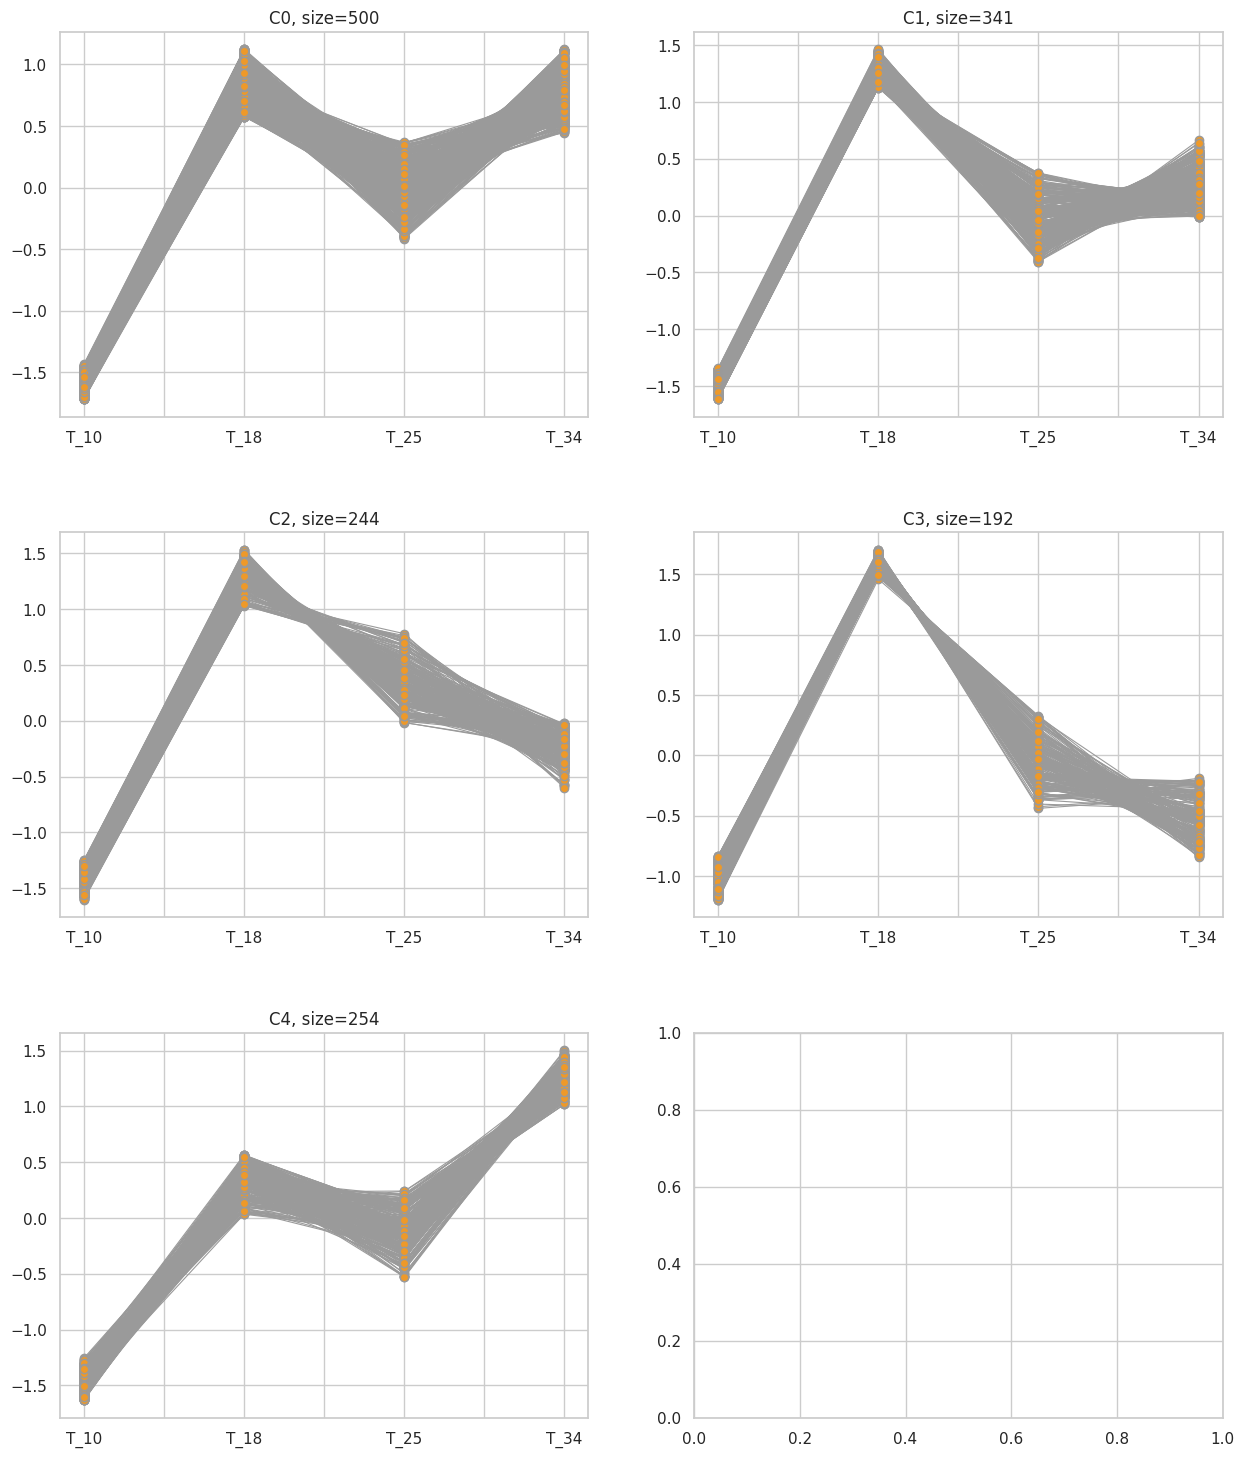

In [24]:
VI.plotClusters(plot_cluster_data_TCZ, clusters_TCZ)

## Cluster TV data

In [30]:
# Using Transcripts/cell
clust_tightness = 1
res_id = 'CLUSTER_ONLY_TEMP_DE_GENES_TRANSCRIPT_VOLUME_ZSCORES'
workdir = os.path.join(os.getcwd(), data_dir / 'clust_input')
outdir = os.path.join(os.getcwd(), results_dir / 'clust' / res_id)

clusters_TVZ = CA.getGeneClusters(TVnoDE,path_to_wd=workdir, 
                              out_dir=outdir,
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization_only_zscores.txt',
                              replicates_file='clust_replicates_merged_L_D_volume.txt',
                              scaling_factor=1e5)

# Plot clusters
plot_cluster_data_TVZ = pd.read_csv(os.path.join(
    os.getcwd(),results_dir / "clust" / f'{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 14 June 2023 (09:23:20)                    |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

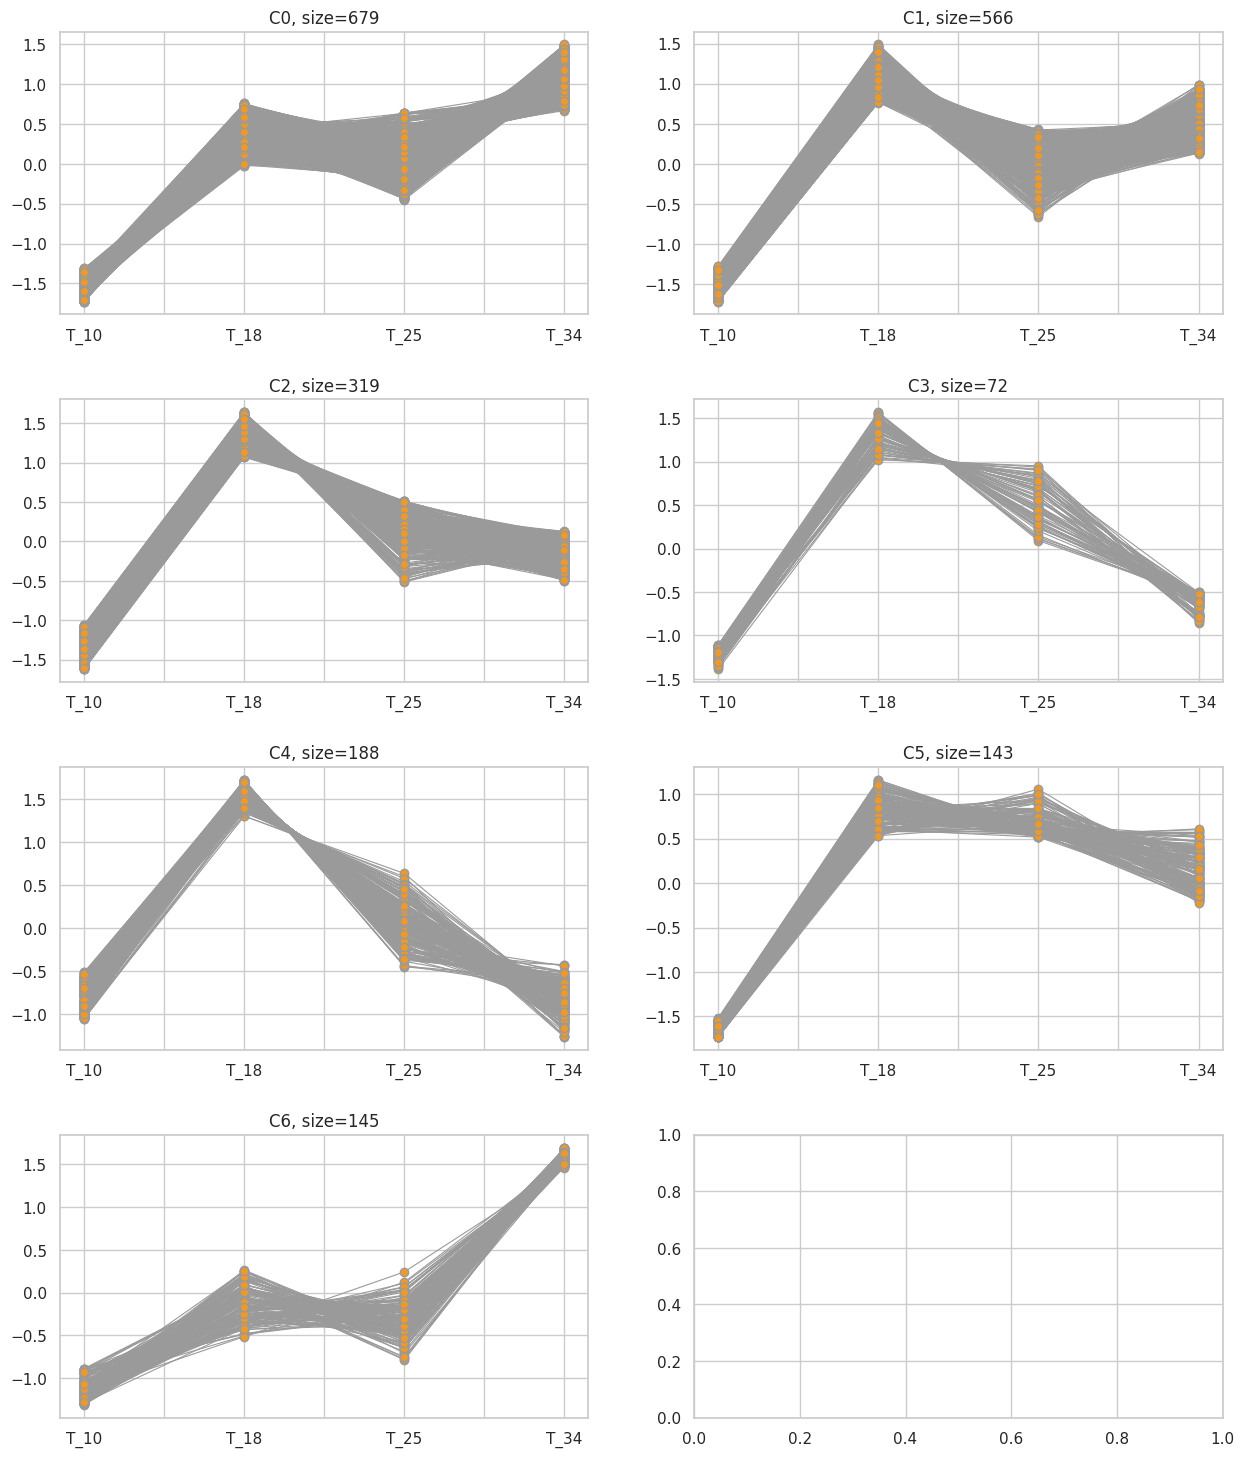

In [31]:
VI.plotClusters(plot_cluster_data_TVZ, clusters_TVZ)

## Comparing gene expression across temperatures after adjusting for cell abundance

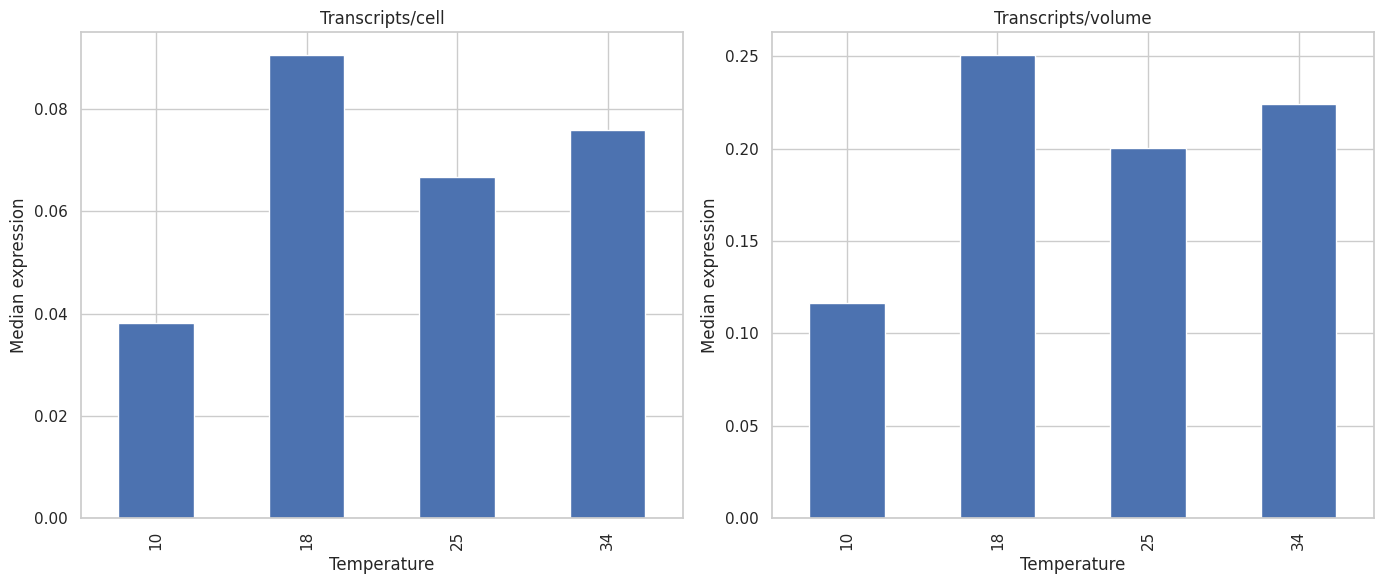

In [36]:
TC_avg = take_average_values(TC_new, method='median')
TV_avg = take_average_values(TV, method='median')
TC_avg_Z = z_normalize(take_average_values(TC_new, method='median'))
TV_avg_Z = z_normalize(take_average_values(TV, method='median'))

# Plot total average expression across temperature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
ax = TC_avg.median().plot(kind='bar', ax=axes[0], title='Transcripts/cell')
ax.set_xlabel('Temperature')
ax.set_ylabel('Median expression')
ax1 = TV_avg.median().plot(kind='bar', ax=axes[1], title='Transcripts/volume')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Median expression')
plt.tight_layout()
plt.show()

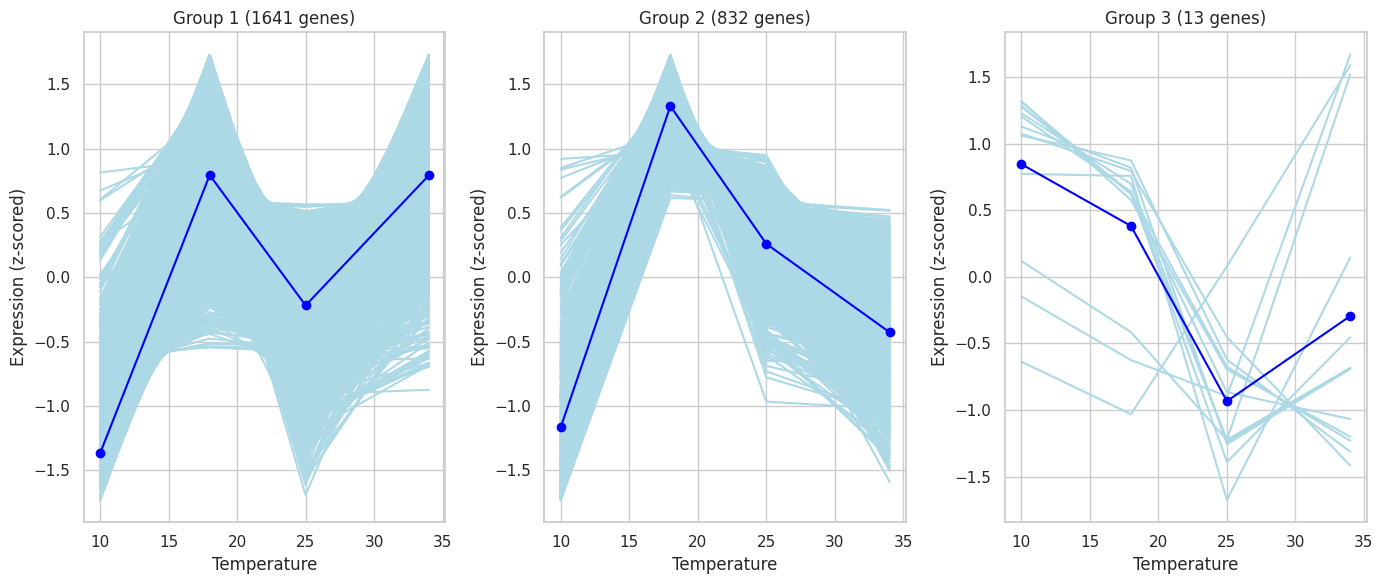

In [28]:
group1 = TV_avg_Z[(
    (TV_avg_Z[10] < TV_avg_Z[18]) &
    (TV_avg_Z[18] > TV_avg_Z[25]) &
    (TV_avg_Z[25] < TV_avg_Z[34])
    )]

# group2 = TV_avg_Z[TV_avg_Z[10] > TV_avg_Z[18]]
# group2 = TV_avg_Z[~TV_avg.index.isin(group1.index)]

group2 = TV_avg_Z[(
    (TV_avg_Z[10] < TV_avg_Z[18]) &
    (TV_avg_Z[18] > TV_avg_Z[25]) &
    (TV_avg_Z[25] > TV_avg_Z[34])
    )]

group3 = TV_avg_Z[TV_avg_Z[10] > TV_avg_Z[18]]


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Calculate mean for group 1
mean1 = group1.mean()

# Plot the data for each gene in group 1 on the first subplot
for index, row in group1.iterrows():
    axes[0].plot(row.index, row, color='lightblue')

# Plot the mean for group 1 on top
mean1.plot(ax=axes[0], color='blue', marker='o')

axes[0].set_title(f'Group 1 ({group1.shape[0]} genes)')
axes[0].set_ylabel('Expression (z-scored)')
axes[0].grid(True)

# Calculate mean for group 2
mean2 = group2.mean()

# Plot the data for each gene in group 2 on the second subplot
for index, row in group2.iterrows():
    axes[1].plot(row.index, row, color='lightblue')

# Plot the mean for group 2 on top
mean2.plot(ax=axes[1], color='blue', marker='o')

axes[1].set_title(f'Group 2 ({group2.shape[0]} genes)')
axes[1].set_ylabel('Expression (z-scored)')
axes[1].grid(True)


# Calculate mean for group 2
mean3 = group3.mean()

# Plot the data for each gene in group 2 on the second subplot
for index, row in group3.iterrows():
    axes[2].plot(row.index, row, color='lightblue')

# Plot the mean for group 2 on top
mean3.plot(ax=axes[2], color='blue', marker='o')

axes[2].set_title(f'Group 3 ({group3.shape[0]} genes)')
axes[2].set_ylabel('Expression (z-scored)')
axes[2].grid(True)

# Improve the layout
plt.tight_layout()
plt.show()

The question is: do we want to compare absolute expression values across temperatures or relative values which are corrected by library size and cell abundance?

In the first case, almost all genes follow the first pattern above, i.e., expression values are lower at 10 degrees and higher at 18 degrees. This is because there is less total RNA per cell at 10 degrees. Thus, when comparing gene expression across temperatures, gene expression will tend to be smaller at 10 for any gene. Is it fair to compare gene expression for a given gene across temperatures considering than the RNA pool per cell is smaller at 10?